<a href="https://colab.research.google.com/github/tony-wade/optimizers/blob/main/Base_SA_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import torch.nn as nn
from typing import List, Optional, Tuple, Callable
from abc import ABC, abstractmethod

In [ ]:
class MemoryPool:
    """
    A memory buffer for storing and managing historical data points. Can be used to create
    n-best memory or recent-n data pool.

    Attributes:
        memory (torch.Tensor): The internal buffer with a size of `(Num, dim)`.
                               `Num` is the total number of data points stored,
                               and `dim` is the dimensionality of a single data point.
    Args:
        size (int, optional): The maximum number of data points to store in the memory pool.(Defaults: 5)
    """
    def __init__(self, size: int = 5) -> None:
        self.memory_num: int = size
        self.memory: Optional[torch.Tensor] = None
        self.next_idx = 0  # index for recent memory buffer

    @torch.no_grad()
    def update_best(self, loss: torch.Tensor, params_flat: torch.Tensor) -> None:
        if self.memory is None:
            # Initialize memory, increment
            entry = torch.cat([loss.view(1), params_flat], dim=0)
            self.memory = entry.unsqueeze(0)
        elif self.memory.size(0) < self.memory_num:
            # Fill the pool
            entry = torch.cat([loss.view(1), params_flat], dim=0)
            self.memory = torch.cat([self.memory, entry.unsqueeze(0)], dim=0)
        else:
            # Replace
            max_loss, max_index = torch.max(self.memory[:, 0], dim=0)

            if loss > max_loss:
                return

            # Replace with new entry
            self.memory[max_index] = torch.cat([loss.view(1), params_flat], dim=0)

    @torch.no_grad()
    def update_recent(self, loss: torch.Tensor, params_flat: torch.Tensor) -> None:
        if self.memory is None:
            # Initialize memory
            entry = torch.cat([loss.view(1), params_flat], dim=0)
            self.memory = entry.unsqueeze(0).repeat(self.memory_num, 1)  # fill with input value
            self.next_idx = 1
        else:
            # update
            self.memory[self.next_idx] = torch.cat([loss.view(1), params_flat], dim=0)
            self.next_idx = (self.next_idx + 1) % self.memory_num

    def get_latest_loss(self) -> Optional[Tuple[float, torch.Tensor]]:
        """Retrieve the (loss, flattened parameters) with the recent loss."""
        return self.memory[self.next_idx - 1, 0]

    def get_min(self) -> Optional[Tuple[float, torch.Tensor]]:
        """Retrieve the (loss, flattened parameters) with the lowest loss."""
        if self.memory is None:
            print('Memory pool is empty')
            return None

        #print(self.memory[:, 0])
        min_loss, min_index = torch.min(self.memory[:, 0], dim=0)
        min_params = self.memory[min_index, 1:]
        return min_loss, min_params

    @torch.no_grad()
    def get_point(self) -> Optional[Tuple[float, torch.Tensor]]:
        """
        Retrieve Tensor tuple (loss, flattened parameters) from memory based on a weighted sampling strategy.
        """
        if self.memory is None:
            return None

        # Sample an index
        losses = self.memory[:, 0]  # Extract losses
        softmax_weights = torch.softmax(-losses / (losses.sum() + 1e-8), dim=0)
        idx = torch.multinomial(softmax_weights, num_samples=1).squeeze()  # 可直接作為索引

        # Retrieve loss and flattened parameters
        entry = self.memory[idx]
        loss = entry[0]
        params_flat = entry[1:]

        return loss, params_flat

In [ ]:
class ScheduleBase(ABC):
    """
    Abstract base class for temperature schedule.

    Args:
        initial_temp (float): The starting temperature at the beginning of the schedule.
        cooling_rate (float): The rate at which the temperature decreases.
        lowest_temp (float, optional): The minimum temperature that the schedule can reach. Defaults to 0.
    """
    def __init__(self, initial_temp: float, cooling_rate: float, lowest_temp: float = 0):
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.lowest_temp = lowest_temp

    @abstractmethod
    def _calculate_temp(self, step: int) -> float:
        """
        Abstract method for the specific cooling rule.

        Args:
            step (int): The current iteration or epoch number.

        Return:
            float: The calculated temperature.
        """
        pass


    def update(self, step: int) -> float:
        """Calculate the temperature for the given step."""
        temp = self._calculate_temp(step)
        return max(temp, self.lowest_temp)


    def plot_schedule(self, num_epochs: int):
        temp_list = []

        for step in range(num_epochs):
            temp = self.update(step)
            temp_list.append(temp)

        plt.figure(figsize=(10, 6))
        plt.plot(temp_list, label='Temperature')
        plt.xlabel('Epochs')
        plt.ylabel('Temperature')
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
class SharkTeethAnnealing(ScheduleBase):
    """
    Args:
        initial_temp (float): The starting temperature for the annealing process.
        cooling_rate (float): A factor that determines how quickly the temperature decreases.
        annealing_period (int): The number of steps over which the temperature will decrease.
        frequency_exponent (float, optional): An exponent that controls the rate of temperature decay. Defaults to 1.
        lowest_temp (float, optional): The minimum temperature the system can reach. Defaults to 0.
    """
    def __init__(self, initial_temp: float, cooling_rate: float, annealing_period: int, frequency_exponent: float = 1, lowest_temp: float = 0):
        super().__init__(initial_temp, cooling_rate, lowest_temp)
        self.annealing_period = annealing_period
        self.frequency_exponent = frequency_exponent

    @torch.no_grad
    def _calculate_temp(self, step: int) -> float:
        decrease_ratio = self.cooling_rate ** (step / self.annealing_period)
        freq = step ** self.frequency_exponent
        phi = (freq % self.annealing_period) / self.annealing_period
        if phi >= 0.5:
            phi -= 0.5
        cos_val = math.cos(2 * math.pi * phi)
        return (self.initial_temp * (1 + cos_val) / 2) * decrease_ratio

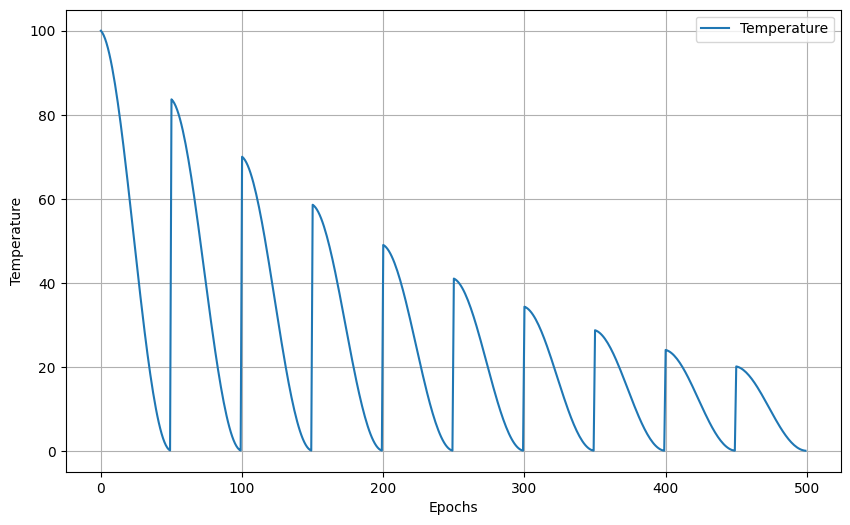

In [ ]:
schedule = SharkTeethAnnealing(100, 0.7, 100, 1.0)
schedule.plot_schedule(500)

In [ ]:
class PiecewiseAnnealing(ScheduleBase):
    """
    Args:
        initial_temp (float): The starting temperature at step 0.
        cooling_rate (float): The decay coefficient for the exponential part of the schedule. A smaller value accelerates cooling.
        plateau_rate (float): A factor that determines the decay rate of the initial sigmoid curve. Lower values lead to a more gradual decay.
        shift_period (int): The step number where the cooling strategy transitions from a sigmoid to an exponential decay.
        scale (int, optional): A calibration coefficient that adjusts the overall shape of the temperature curve. Defaults to 100.
        lowest_temp (float, optional): The minimum temperature that the schedule will reach. Defaults to 0.
    """
    def __init__(self, initial_temp: float, cooling_rate: float, plateau_rate: float, shift_period: int, scale: int = 100, lowest_temp: float = 0):
        super().__init__(initial_temp, cooling_rate, lowest_temp)
        self.plateau_rate = plateau_rate
        self.shift = shift_period
        self.scale = scale
        self.transit_temp = self.initial_temp * self._sigmoid(shift_period)

    def _sigmoid(self, step):
        return 1 / (1 + math.exp((step-self.shift) * (10*self.plateau_rate) / self.scale))

    @torch.no_grad
    def _calculate_temp(self, step: int) -> float:
        if step <= self.shift:
            sigmoid_val = self._sigmoid(step)
            temp = self.initial_temp * sigmoid_val
        else:
            temp = self.transit_temp * self.cooling_rate ** ((step-self.shift) / self.scale)

        return temp

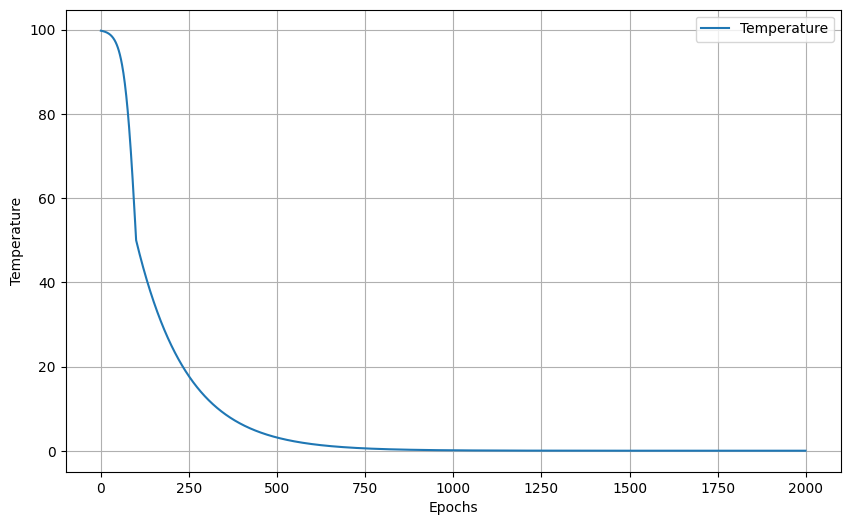

In [ ]:
schedule = PiecewiseAnnealing(100, 0.5, 0.6, 100)
schedule.plot_schedule(2000)

In [ ]:
class ParamSamplerBase(ABC):
    """
    A base class for sampling parameters with configurable boundaries.
        Args:
        bounds (tuple[float, float] | list[tuple[float, float]] | None):
            Defines the range(s) for the parameters. Can be:
            - A single tuple `(min, max)` for all parameters.
            - A list of tuples `[(min1, max1), ...]` for each parameter.
            - `None` if the parameters are unbounded.
        boundary_mode (str, optional): The behavior for handling values outside the bounds.
            Options are "reflect" (reflects values back into the range)
            or "circular" (wraps values around the range). Defaults to "reflect".
        batch_size (int, optional): The number of samples to generate in each batch. Defaults to 10.
        device: The PyTorch device to use for tensor operations. Defaults to 'cpu' if not specified.
    """
    def __init__(
        self,
              bounds: tuple[float, float] | list[tuple[float, float]] | None,
              boundary_mode: str = "reflect" ,
              batch_size: int = 10,
              device=None
              ):
        self.bounds = bounds
        self.boundary_mode = boundary_mode
        self.batch_size: int = batch_size
        self.batch_sample = None
        self.batch_pointer = 0
        self.device = device if device else torch.device('cpu')
        self.mean = None
        self.std = None

    def bound_setup(self, param_size: Optional[int] = None):
        """
        Sets up and validates the bounds for the sampler.

        This method converts the input `bounds` into a PyTorch tensor and
        handles different input formats (single tuple or a list of tuples).

        Args:
            param_size (int, optional): The number of parameters to sample. Required
                                        if `bounds` is provided as a single tuple.

        Raises:
            ValueError: If `bounds` is not a valid type.
        """
        if isinstance(self.bounds, list):
            # provide each variable's range
            self.bounds = torch.tensor(self.bounds, device=self.device, dtype=torch.float32)
        elif isinstance(self.bounds, tuple) and param_size:
            # all in same range
            self.bounds = torch.tensor([self.bounds] * param_size, device=self.device, dtype=torch.float32)
        else:
            raise ValueError("Bounds must be a list or a tuple.")

    @torch.no_grad()
    def wrap(self, value: torch.Tensor) -> torch.Tensor:
        """
        Wraps a tensor's values to be within the defined bounds.

        This method handles out-of-bounds values using either a "circular" or "reflect"
        boundary mode, as specified during initialization. This is useful for
        keeping values within a valid search space.

        Args:
            value (torch.Tensor): The tensor of values to be wrapped.

        Returns:
            torch.Tensor: The wrapped tensor, with all values within the specified bounds.

        Raises:
            ValueError: If an invalid `boundary_mode` is provided.
        """
        if self.bounds is None:
            return value    # Not bounded

        lower_bound, upper_bound = self.bounds[:,0], self.bounds[:,1]

        if self.boundary_mode == "circular":
            return lower_bound + (value - lower_bound).fmod(upper_bound - lower_bound)
        elif self.boundary_mode == "reflect":
            range_ = upper_bound - lower_bound
            d = value - lower_bound
            d_mod = torch.remainder(d, 2 * range_)
            return lower_bound + (range_ - torch.abs(range_ - d_mod))
        else:
            raise ValueError("Invalid boundary_mode: expected 'circular' or 'reflect'")

    @torch.no_grad()
    def standardize(self, params: torch.Tensor) -> torch.Tensor:
        '''standardize batch params'''
        mins, _ = params.min(dim=0)  # value, indices
        maxs, _ = params.max(dim=0)
        range_ = (maxs - mins).clamp(min=1e-6)
        norm = 1.0 / range_
        self.mean = torch.mean(params, dim=0)   # record
        self.std = torch.sqrt((norm * ((params - self.mean) ** 2)).sum(0)).clamp(min=1e-2)
        return (params - self.mean) / self.std

    @torch.no_grad()
    def unstandardize(self, params: torch.Tensor) -> torch.Tensor:
        return self.mean + self.std * params

    @torch.no_grad()
    def normalize(self, point: torch.Tensor) -> torch.Tensor:
        '''Normalize 1D tensor point, will rescale first if param is in different unit(bounded)'''
        if self.bounds is None:
            rescale_point = point
        else:
            lower = self.bounds[:, 0]
            upper = self.bounds[:, 1]
            rescale_point = (point - lower) / (upper - lower)

        return rescale_point / torch.dot(rescale_point, rescale_point)

    @torch.no_grad()
    def cal_log_weight(self, ascending_input: torch.Tensor) -> torch.Tensor:
        '''Get Logarithmic Decay Weight'''
        input_size = len(ascending_input)

        if input_size == 0:
            raise ValueError('At least 1 element needs to be provided')
        elif input_size == 1:
            return torch.tensor([1.0], device=ascending_input.device)
        else:
            diffs = (ascending_input[1:] - ascending_input[:-1]).float()
            norm_diffs = diffs / diffs.sum()

            if diffs.sum() < 1e-1:
                return torch.ones(input_size) / input_size  # all small enough
            else:
                order = torch.arange(1, input_size+1, dtype=torch.float, device=ascending_input.device)
                adjust_val = torch.zeros_like(order)

                for idx in range(input_size-1):
                    value = norm_diffs[idx]
                    if value < (1/input_size * 0.25):
                        adjust_val[idx+1:] += 1.0
                    else:
                        adjust_val[idx+1:] += (value * input_size)

                order += adjust_val
                log_values = (torch.log((input_size + 0.5) / order)).clamp(min=0.0)
                sum_log_values = log_values.sum()
                return log_values / sum_log_values

    @torch.no_grad()
    def cal_softmax_weight(self, ascending_input: torch.Tensor, tau: Optional[float] = None,
                          clip_min: float = 0.01, clip_max: float = 0.5, eps: float = 1e-8) -> torch.Tensor:
        """Softmax-based weights (lower loss -> higher weight).  """
        input_size = ascending_input.numel()
        device = ascending_input.device

        if input_size == 0:
            raise ValueError("At least 1 element needs to be provided")
        if input_size == 1:
            return torch.tensor([1.0], device=device, dtype=ascending_input.dtype)

        vals = ascending_input.float().to(device)
        # shift so smallest loss gets largest logit
        shifted = vals - vals.min()

        # determine temperature
        std_val = torch.std(vals)
        if tau is None:
            tau = std_val if std_val.item() > 1e-6 else torch.tensor(1.0, device=device, dtype=vals.dtype)
        else:
            tau = torch.tensor(float(tau), device=device, dtype=vals.dtype)

        logits = -shifted / tau
        w = torch.softmax(logits, dim=0)

        # clip extreme weights and re-normalize
        w = torch.clamp(w, min=float(clip_min), max=float(clip_max))
        return w / (w.sum() + eps)

    @torch.no_grad()
    def create_ortho_set(self, dimension: int, num_vectors: int) -> torch.Tensor:
        '''Generate (num_vectors, dimension) orthonormal vectors'''
        selected_indices = torch.randperm(dimension, device=self.device)[:num_vectors]
        ortho_vectors = torch.zeros(num_vectors, dimension, device=self.device)
        ortho_vectors[torch.arange(num_vectors, device=self.device), selected_indices] = 1.0
        return ortho_vectors

    @torch.no_grad()
    def householder_align(self, unit_vec_set: torch.Tensor, point: torch.Tensor) -> torch.Tensor:
        """
        Aligns a set of unit vectors to a target direction using a Householder reflection.

        Args:
            unit_vec_set (torch.Tensor): A tensor of unit vectors with shape `(N, D)`,
                                         where `N` is the number of vectors and `D` is the dimension.
            point (torch.Tensor): A tensor representing the target direction, with shape `(D,)`.

        Returns:
            torch.Tensor: The transformed tensor of unit vectors, now aligned with the target direction.
        """
        ref_dir = unit_vec_set[0, :]  # take first vector as reference
        target_dir = self.normalize(point)
        householder_vec = ref_dir - target_dir
        hh_norm = torch.dot(householder_vec, householder_vec)

        if hh_norm < 1e-6:
            return unit_vec_set
        else:
            return unit_vec_set - (2 / hh_norm) * torch.outer(unit_vec_set @ householder_vec, householder_vec)  # column vec

    @staticmethod
    @torch.no_grad()
    def cal_svd(inputs: torch.Tensor, k_best: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Performs a reduced Singular Value Decomposition (SVD) and returns the top components.

        This method computes the SVD of the input tensor and returns the `k_best`
        principal components for dimensionality reduction.

        Args:
            inputs (torch.Tensor): The input tensor for SVD, typically with shape `(batch_size, param_size)`.
            k_best (int, optional): The number of principal components to keep.
                                    If None, all components are returned. Defaults to None.

        Returns:
            tuple[torch.Tensor, torch.Tensor, torch.Tensor]: A tuple containing the top SVD components:
                - U (torch.Tensor): The left singular vectors.
                - S (torch.Tensor): The singular values, returned as a column vector.
                - Vh (torch.Tensor): The right singular vectors.
        """
        # return size; (batch size, num_S), (num_S, 1), (num_S, param size)
        U, S, Vh = torch.linalg.svd(inputs, full_matrices=False)  # reduced
        principle_num = min(k_best, S.numel()) if k_best else S.numel()   # for dim reduction
        return U[:,:principle_num], S[:principle_num].unsqueeze(1), Vh[:principle_num, :]  # need conjugate when complex

In [ ]:
class SimulatedAnnealingBase(torch.optim.Optimizer, ABC):
    """
    An abstract base class for implementing simulated annealing optimizers.

    Args:
        params: Iterable of parameters to optimize or dicts defining parameter groups.
             This is the standard `params` argument for PyTorch optimizers.
        sampler (ParamSamplerBase | list[ParamSamplerBase]):
             The sampler used to generate new candidate solutions. Can be a single
             sampler for all parameter groups or a list of samplers, one per group.
        schedule (ScheduleBase | list[ScheduleBase]):
             The temperature schedule that controls the probability of accepting
             a worse solution. Can be a single schedule or a list of schedules.
    """
    def __init__(
        self,
        params,
        sampler: ParamSamplerBase | List[ParamSamplerBase],
        schedule: ScheduleBase | List[ScheduleBase],
    ):
        super().__init__(params, defaults={})

        self._step_count = 0

        n_groups = len(self.param_groups)

        # unique or same one
        schedule_list = schedule if isinstance(schedule, (list,tuple)) else [schedule]*n_groups
        sampler_list = sampler if isinstance(sampler, (list,tuple)) else [sampler]*n_groups

        for g, sched, samp in zip(self.param_groups, schedule_list, sampler_list):
            g['temperature'] = sched.initial_temp
            g['loss'] = torch.tensor(float('inf'))
            g['param_vec'] = torch.nn.utils.parameters_to_vector(g['params'])
            g['schedule'] = sched
            g['sampler'] = samp


    def get_loss_value(self, group_idx: int = 0) -> float:
        if not (0 <= group_idx < len(self.param_groups)):
            raise IndexError(f"group_idx should be in 0～{len(self.param_groups)-1}")
        return self.param_groups[group_idx]['loss'].item()


    def get_temperatures(self, decimals: int = 2) -> List[float]:
        return [round(g['temperature'], decimals) for g in self.param_groups]


    @abstractmethod
    def _update_state(self, group: Dict[str, Any], new_loss: Union[float, torch.Tensor], **kwargs):
        """
        Update the group's state after accepted a candidate solution.

        This includes updating:
        - loss
        - temperature (via schedule)
          ...

        Note:
        - This method should NOT increment `self._step_count`; that is the responsibility of the outer `step()` method.
        - Override in subclasses to customize acceptance logic.
        """
        # group['loss'] = new_loss
        # group['temperature'] = group['schedule'].update(self._step_count)
        pass


    @abstractmethod
    def step(self, closure):
        """
        Perform one optimization step.

        This should:
        - Increment self._step_count
        - Evaluate loss using closure
        - Propose a candidate
        - Call _update_state for each group

        Parameters:
            closure (callable): A function that re-evaluates the model and returns the loss.
        """
        pass